In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, LSTM, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Activation, dot
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Adagrad, Nadam, Ftrl
from keras.utils import plot_model, model_to_dot
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import keras.backend as K
import datetime
from tensorflow.keras import regularizers
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()

In [25]:
def quantile_loss(quantile):
    def loss(y_true, y_pred):
        e = y_true - y_pred
        return tf.reduce_mean(tf.maximum(quantile * e, (quantile - 1) * e), axis=-1)
    return loss

def truncate(x, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=100, test_len=20):
    in_, out_= [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
    return np.array(in_), np.array(out_)
X_in, X_out = truncate(df1, feature_cols=range(1), target_cols=range(1),label_col=1, train_len=12, test_len=1)
print(X_in.shape, X_out.shape)

(353, 12, 1) (353, 1, 1)


In [26]:

train_x = X_in[:math.floor(X_in.shape[0]*0.70)]
train_y = X_out[:math.floor(X_out.shape[0]*0.70)]
test_x = X_in[math.floor(X_in.shape[0]*0.70):]
test_y = X_out[math.floor(X_out.shape[0]*0.70):]
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(247, 12, 1) (247, 1, 1) (106, 12, 1) (106, 1, 1)


In [27]:
df = pd.read_csv(r'C:\Users\aades\Downloads\LSTM_Experiment\LSTM_Experiment\Datasets\daily-total-female-births-CA.csv',index_col='date', parse_dates=True)
df["births"]=df["births"].astype(float)
df.head()

df1 = df.to_numpy()

In [28]:
def create_quantile_lstm(input_shape, output_dim=1):  
    initializer = tf.keras.initializers.GlorotNormal(seed=None)
    input_train = Input(shape=input_shape)

    x = LSTM(100, activation='relu', kernel_initializer=initializer, return_sequences=False)(input_train)
    out = Dense(output_dim)(x)
    
    model = Model(inputs=input_train, outputs=out)
    return model

quantile1 = create_quantile_lstm((12, 1), output_dim=1)
quantile2 = create_quantile_lstm((12, 1), output_dim=1)


In [29]:

q1 = 0.01
q2 = 0.96 

quantile1.compile(loss=quantile_loss(q1), optimizer=Adam(learning_rate=0.05))
quantile2.compile(loss=quantile_loss(q2), optimizer=Adam(learning_rate=0.05))


In [30]:
epc = 300
stop_patience = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')

start_time = datetime.datetime.now()
history = quantile1.fit(train_x, train_y, validation_split=0.1, epochs=epc, verbose=1, batch_size=64
                         )
end_time = datetime.datetime.now()
total_time1 = round((end_time - start_time).total_seconds(), 2)
print('seconds taken for quantile1:', total_time1,
      '\nstart_time:', start_time.strftime('%H:%M:%S'),
      'end_time:', end_time.strftime('%H:%M:%S'))


stop_patience = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
start_time = datetime.datetime.now()
history = quantile2.fit(train_x, train_y, validation_split=0.1, epochs=epc, verbose=1, batch_size=64
                        )
end_time = datetime.datetime.now()
total_time2 = round((end_time - start_time).total_seconds(), 2)
print('seconds taken for quantile2:', total_time2,
      '\nstart_time:', start_time.strftime('%H:%M:%S'),
      'end_time:', end_time.strftime('%H:%M:%S'))


Epoch 1/300
4/4 [==============================] - 2s 93ms/step - loss: 1949.2864 - val_loss: 0.4750
Epoch 2/300
4/4 [==============================] - 0s 21ms/step - loss: 0.4908 - val_loss: 0.6465
Epoch 3/300
4/4 [==============================] - 0s 19ms/step - loss: 0.5671 - val_loss: 0.5345
Epoch 4/300
4/4 [==============================] - 0s 18ms/step - loss: 0.4502 - val_loss: 0.5159
Epoch 5/300
4/4 [==============================] - 0s 17ms/step - loss: 0.4653 - val_loss: 0.5158
Epoch 6/300
4/4 [==============================] - 0s 19ms/step - loss: 0.4623 - val_loss: 0.5092
Epoch 7/300
4/4 [==============================] - 0s 24ms/step - loss: 0.4562 - val_loss: 0.5057
Epoch 8/300
4/4 [==============================] - 0s 20ms/step - loss: 0.4544 - val_loss: 0.5039
Epoch 9/300
4/4 [==============================] - 0s 20ms/step - loss: 0.4522 - val_loss: 0.5013
Epoch 10/300
4/4 [==============================] - 0s 20ms/step - loss: 0.4498 - val_loss: 0.4982
Epoch 11/300
4/4

Total training time for both quantile1 and quantile2: 46.03 seconds
PICP: 0.9609291562833748
MPIW: 35.44


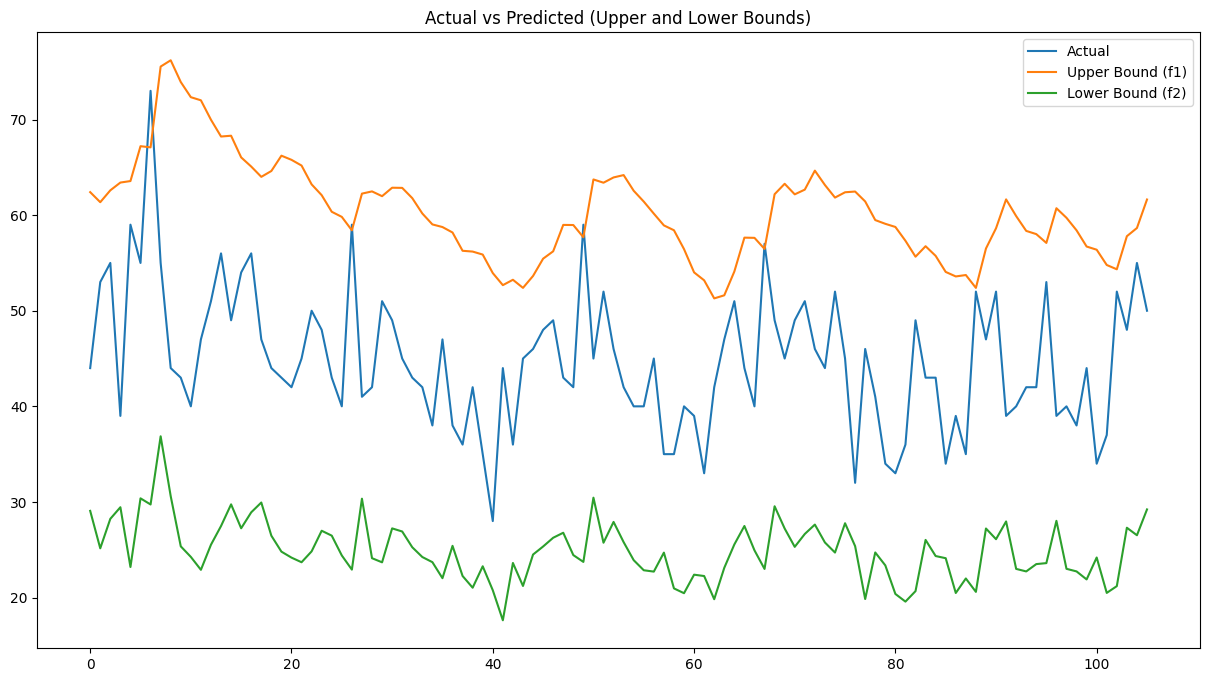

In [31]:
y_l_pred = quantile1.predict(test_x, verbose=0)
y_u_pred = quantile2.predict(test_x, verbose=0)
test_y_ = np.squeeze(test_y[:,0])
K_u = y_u_pred > test_y_
K_l = y_l_pred < test_y_
PICP = np.mean(K_u * K_l)
MPIW = np.round(np.mean(y_u_pred - y_l_pred), 3)
total_training_time = total_time1 + total_time2
print('Total training time for both quantile1 and quantile2:', total_training_time, 'seconds')

print('PICP:', PICP)
print('MPIW:', MPIW)


actual = np.squeeze(test_y)
pred1 = y_u_pred
pred2 = y_l_pred
numEx = range(len(actual))
plt.figure(figsize=(15, 8))
plt.plot(numEx, actual, label='Actual')
plt.plot(numEx, pred1, label='Upper Bound (f1)')
plt.plot(numEx, pred2, label='Lower Bound (f2)')
plt.legend(loc='best')
plt.title('Actual vs Predicted (Upper and Lower Bounds)')
plt.show()